# Time Series Feature Engineering

This notebook gives a demo of how feature engineering can be applied to a time series dataset in order to pass the dataset to a supervised model

In [1]:
\l ml/ml.q
\l ml/init.q
\l ../code/arimamdl.q
\l ../code/utils.q
\l ../code/feat.q
\l ../code/graphics.q
\l ../utils.q

plt:.p.import[`matplotlib.pyplot]

### Data Preparation

Load in the data

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [2]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

Missing timestamps values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [3]:
// Include any missing datetimes
bikes:datefill[`timestamp;bikes;01:00:00.000]

// Timestamp component is broken into its constituent parts
bikes:.ml.timesplit[bikes;`timestamp]

// Back and forward fill the missing data
bikes:.ml.dropconstant[.ml.filltab[bikes;();`timestamp;::]]

In [4]:
// Delete any null_ cols - too many 0 values for model to preform well
delcols:cols[bikes] where cols[bikes] like"*_null"

bikes:![bikes;();0b;delcols]

## Feature Engineering

### Important things to note

#### Forecast Point
When creating features in a time series dataset, knowing how at what point in the past the features are being made (the `Forecast Point`) is important to ensure that no data leakage occurs. This means that if forecasts are being made for the following week, then features can only be created up to the week before, at the time of prediction. Adding features during training that are not available during testing will skew the results.

#### Available Features at Prediction Time 
Also for future forecasts, knowing what exogenous variables that you'll have when making the forecasts is important. If the future value of a column will not be available at the time of prediction then it should not be included in the training of the model.

For the below example, we are assuming that the future values of the weather columns will not be availble. Only lagged and windowed feature weather columns will be included

#### Length of Lagged/ Window Features to use
When deciding what lagged and window lengths to use, it is also worth noting that the larger the length that you use, the less data that is available for training. For example, if a lagged period of `N` is chosen, then the first `N` rows will have to removed as the features are null.

#### Predicting future values
When predicting future values, it is important that the correct amount of past values is given to the model so that it can create the appropriate features for predictions. i.e if the lagged feature length is 1 week, then to predict the next value, at least 1 week of past values must be given to the model 

### Lagged Values

`addFeatLag`

Add lagged feature columns to the dataset

`tab` - table to create the features from

`n` - list of past values (from forecast point) to extract

`fp` - forecast point (the time a prediction is being made)

`col` - list of columns to extract the past values from 

The function returns a the table with the additional lagged feature columns

In the below example we are extracting previous values on all columns except columns that were produced from `.ml.timesplit` and any other time based feature. Previous values at times 12, 24 and 168 hours in the past are extracted. The forecast point here is 24 hours (i.e we are predicting 24 hours in the future, so we are assuming that we are only using values that we have 24 hours before the intended prediction time)

In [5]:
// Choose what columns to extract features from 

// remove timestamp cols from list
collst:cols[bikes] where not cols[bikes]like "*timestamp*"
collst:collst except `season`is_weekend

In [6]:
show lagtab:.tm.addFeatLag[bikes;12 24;24;collst]

cnt  t1  t2   hum  wind_speed weather_code is_weekend season timestamp_dow ti..
-----------------------------------------------------------------------------..
182  3   2    93   6          3            1          3      1             20..
138  3   2.5  93   5          1            1          3      1             20..
134  2.5 2.5  96.5 0          1            1          3      1             20..
72   2   2    100  0          1            1          3      1             20..
47   2   0    93   6.5        1            1          3      1             20..
46   2   2    93   4          1            1          3      1             20..
51   1   -1   100  7          4            1          3      1             20..
75   1   -1   100  7          4            1          3      1             20..
131  1.5 -1   96.5 8          4            1          3      1             20..
301  2   -0.5 100  9          3            1          3      1             20..
528  3   -0.5 93   12         3         

Example of new columns created

In [7]:
48_reverse each lagtab

weather_code_xprev_24 weather_code_xprev_12 wind_speed_xprev_24 wind_speed_xp..
-----------------------------------------------------------------------------..
3                     4                     6                   13           ..
1                     3                     5                   15           ..
1                     3                     0                   8            ..
1                     3                     0                   11           ..
1                     3                     6.5                 12           ..
1                     3                     4                   11           ..
4                     3                     7                   6.5          ..
4                     3                     7                   7            ..
4                     3                     8                   4            ..
3                     4                     9                   5            ..
3                     4                 

### Windowed Features

`addFeatWind`

Add windowed feature columns to the dataset

`tab` - table to create the features from

`n` - list of window sizes over which to apply the functions

`fp` - forecast point (the time a prediction is being made)

`col` - list of columns to apply the transformations to

`fnc` - list of symbol functions to apply over the window (eg ``` `min `max `avg ```)

The function returns a the table with the additional windowed feature columns

Similar to above, we are applying windowed features to the same columns using the same forecast point. We choose windowed features of 24, 48 and 186 hours into the past and apply `avg`, `max`, `dev` functions to the data 

In [8]:
show wndtab:.tm.addFeatWind[lagtab;12 24 168;24;collst;`avg`max`dev]

cnt  t1  t2   hum  wind_speed weather_code is_weekend season timestamp_dow ti..
-----------------------------------------------------------------------------..
182  3   2    93   6          3            1          3      1             20..
138  3   2.5  93   5          1            1          3      1             20..
134  2.5 2.5  96.5 0          1            1          3      1             20..
72   2   2    100  0          1            1          3      1             20..
47   2   0    93   6.5        1            1          3      1             20..
46   2   2    93   4          1            1          3      1             20..
51   1   -1   100  7          4            1          3      1             20..
75   1   -1   100  7          4            1          3      1             20..
131  1.5 -1   96.5 8          4            1          3      1             20..
301  2   -0.5 100  9          3            1          3      1             20..
528  3   -0.5 93   12         3         

Example of new columns created

In [9]:
48_reverse each wndtab

weather_code_dev_168 weather_code_dev_24 weather_code_dev_12 weather_code_max..
-----------------------------------------------------------------------------..
1.055272             1.076904            0.4714045           4               ..
1.055417             1.01977             0.4930066           4               ..
1.054093             0.942809            0.5                 4               ..
1.051602             0.8405934           0.4930066           4               ..
1.048185             0.7021791           0.4714045           4               ..
1.044031             0.4982609           0.4330127           4               ..
1.027205             0.5                 0.4330127           4               ..
1.011168             0.4982609           0.4330127           4               ..
0.9958592            0.4930066           0.4330127           4               ..
0.9812251            0.4930066           0.4714045           4               ..
0.9672178            0.4930066          

The data is then split into training and testing sets based on a temporal split. The first 192 hours are dropped to get rid of any null values. Backfilling in this scenario would not be appropriate

In [10]:
// Find the timestamp which splits the data 80/20
tts:ttstm[192_delete cnt,t1,t2,hum,wind_speed,weather_code from wndtab;192_wndtab`cnt;0.2]

// The data is then split into the training and testing sets
xtrainbk:tts`xtrain
ytrainbk:tts`ytrain
xtestbk:tts`xtest
ytestbk:tts`ytest


-1!"There is ",string[count xtrainbk]," datapoints in the training set"
-1!"There is ",string[count xtestbk]," datapoints in the testing set"

"There is 13881 datapoints in the training set"


"There is 3471 datapoints in the testing set"


A significant features test is applied in order to find what features are important when predicting the target value

In [11]:
show newc:.ml.fresh.significantfeatures[xtrainbk;ytrainbk;.ml.fresh.benjhoch 0.05]

-1!"\nThe number of original columns: ",string count cols bikes;
-1!"\nThe number of columns after time series feature engineering: ",string count cols xtrainbk;
-1!"\nThe number of columns that were deemed to be significant: ",string count newc;

`timestamp_hh`cnt_xprev_12`cnt_xprev_24`t1_xprev_24`t2_xprev_24`hum_xprev_12`..


A basic Gradient Boost Regression model is used for predictions.

In [12]:
gbr:.p.import[`sklearn.ensemble]`:GradientBoostingRegressor;

reg:gbr[`random_state pykw 0];

reg[`:fit][flip xtrainbk[newc];ytrainbk];

Predictions are then made on the test data

In [13]:
show predsbk:reg[`:predict][flip xtestbk[newc]]`

-1!"The Root mean squared log error is ",string .ml.rmsle[predsbk;ytestbk]

2076.79 1450.847 1434.441 1674.87 1800.151 1921.182 1991.152 2609.617 3950.95..


"The Root mean squared log error is 0.5678997"


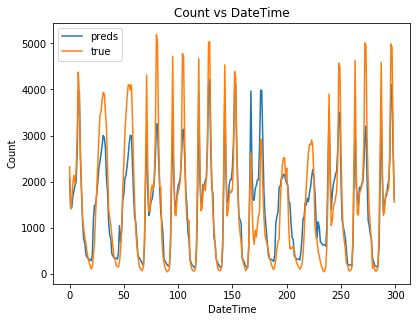

In [14]:
pltresult[300#predsbk;300#ytestbk;"Count"]